In [2]:
#!pip install tensorflow_hub 

In [3]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.5.1
TF Hub version: 0.12.0
GPU available (YESSSS!!!!!)


In [4]:
import random
                       
import pandas as pd                       
import matplotlib.pyplot as plt                       
import numpy as np

In [5]:
df = pd.read_csv('mnist_test.csv')


We use the test file datapoints since they will be excluded from training and therefore our model will not see any of these. Using the test datapoints we will select a subset for us to corrupt. Let’s arbitrarily use the first 1000 (index 0–999) for corruption and leave the remaining 9000 datapoints untouched.

In [6]:
anom = df[:1000]
clean = df[1000:]

In [7]:
anom.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will store the first 1000 rows of mnist_test.csv as our anomalies (don’t worry, later we will shuffle it all up) in a separate DataFrame and join them later.
Next we want to corrupt (add excessive noise) to these 1000 datapoints:

In [8]:
for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

This effectively adds a randThis effectively adds a random amount of noise to each pixel of a MNIST datapoint. It is fairly excessive, but it can be an interesting experiment by changing the level of noise to see how our model reacts. This change can be reflected in ‘randint(lower, upper)’ by giving ‘lower’ 0 and ‘upper’ 255 values. For this article we will use very corrupted data.

Here is what first first five rows of the ‘anom’ DataFrame now (bottom row) looks like compared to before (top row):om amount of noise to each pixel of a MNIST datapoint. It is fairly excessive, but it can be an interesting experiment by changing the level of noise to see how our model reacts. This change can be reflected in ‘randint(lower, upper)’ by giving ‘lower’ 0 and ‘upper’ 255 values. For this article we will use very corrupted data.
Here is what first first five rows of the ‘anom’ DataFrame now (bottom row) looks like compared to before (top row):

Not only are we adding noise, we will also edit the label to a binary annotation: anomalous or non-anomalous, which will be 1 and 0 respectively. We will use this label in the final stage to determine how many anomalies we successfully identified.

In [9]:
anom['label'] = 1
clean['label'] = 0

All that is left is to join up these two DataFrames, shuffle and save it to its own file:

In [10]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

## Autoencoder
The neural network of choice for our anomaly detection application is the Autoencoder. This is due to the autoencoders ability to perform feature extraction as the dimensionality is reduced to build a latent representation of the input distribution. How we can exploit that is by utilizing a loss distribution of rebuilt inputs to outputs (which turns out to be Guassian) and making the assumption that any outliers will be anomalies since they faulter well outside the parameters of what the model considers “within the expected distribution”.

For our purposes the following architecture was used as a simple linear compression from input to latent representation.

In [11]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

## Training and Prediction Setup
Libraries required for training and predicting.

In [12]:
import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

Core training parameters.

In [13]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

Training
Using the model mentioned in the previous section, we will now train on the standard MNIST training dataset (our mnist_train.csv file). Since we’re using the CSV file, we will implement a custom dataset loader with PyTorch.

In [14]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       'mnist_train.csv',
                       index_col=False
                       )

This custom dataset loader removes the label column of each row and normalizes (divides by 255) to a 0–1 range that better serves training efficiency. The ‘Train_Loader’ implements the base class ‘Loader’. It was built this way as a ‘Test_Loader’ class can easily be implemented using the same base class.

In order to enumerate over the dataset during training we extend to the PyTorch DataLoader class:

In [15]:
train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            #num_workers=1,
            pin_memory=True,
            drop_last=True
        )

The training setup includes a dictionary of lists named metrics — this is a personal favorite if I have to track multiple values throughout training. The rest of the parameters are pretty standard. As mentioned before, we will be implemented the MSELoss class as our loss function between output and input.

In [16]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

Now we can train our model with the following loop:


In [17]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0033654114346951245
Epoch Complete in 0:00:55.882000
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.003264253607019782
Epoch Complete in 0:00:56.555031
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0031576461182286344
Epoch Complete in 0:00:57.234009
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0030424837092558545
Epoch Complete in 0:00:54.746991
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.002926768708849947
Epoch Complete in 0:00:58.074002
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0028255631657938163
Epoch Complete in 0:00:56.316001
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0027558970741927624
Epoch Complete in 0:00:54.834997
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.002715326627964775
Epoch Complete in 0:00:48.980035
-------------------

Once training is finished, we output the loss plot to determine if our model has converged to a solution.

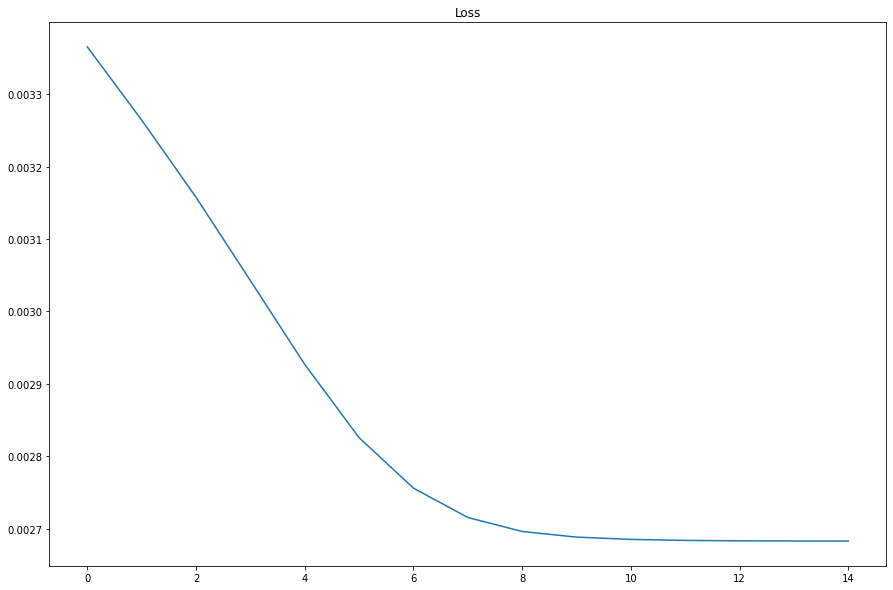

In [18]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

Excellent! It looks like we’ve managed to converge to a solution: the Autoencoder has successfully captured the features of the input distribution within its compressed latent representation.


## Prediction
For our model to determine if an input is or is not an anomaly, we will use the loss value from the output and input — if the loss value is high, then we will assume that the model is seeing an element that is outside of the known distribution representation. To achieve this, we will iterate through our test set sequentially and retaining the loss value. It is very important to perform this task sequentially as this will serve us in our analysis of results

In [19]:
model.eval()
loss_dist = []
anom = pd.read_csv('anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

## Results
Visualizing the loss values will give us valuable insight to where our anomalies are hiding. A simple way of doing this is by projecting each value as a point and observing the plot.

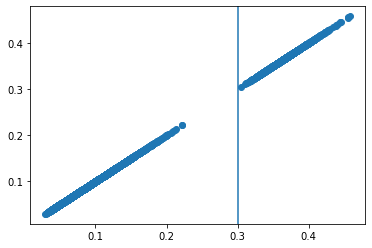

In [20]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

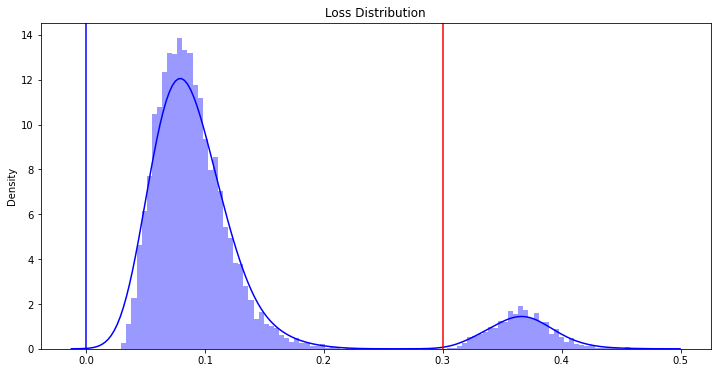

In [21]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In both the above plots of the loss values, you noticed a vertical line. These lines are an estimated threshold value for which we will determine a loss value is or is not an anomaly. In the loss distribution plot, if the value exceed (to the right) of the red line, we will consider that data as an anomaly. There is a blue line that represents a lower threshold (anything below) but is not relevant for this example of data.

Using this upper threshold, we can make predictions on what we consider an anomaly and count the number of occurences as follows:

* TP (True Positive): Both the prediction and label align for anomaly
* FP (False Positive): The prediction determines anomaly but the label is non-anomalout
* TN (True Negative): Both the prediction and label align for non-anomalous
* FN (False Negative): The prediction determines non-anomaly but the label is anomalous

The following code is why it was so important to retain the sequential ordering of our loss values. We match up the loss values to each row within the MNIST anomaly test set we have created. If this ordering was altered then we would be associating the wrong loss value with the wrong input.

In [22]:
df = pd.read_csv('anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


Placing our threshold at 0.3 gives us a 100% success rate for predicting anomalies.

This information can be best visualized as a confusion matrix.


<AxesSubplot:>

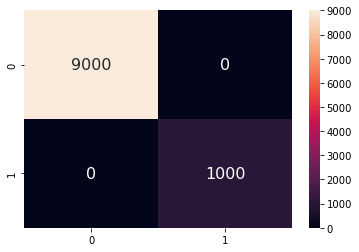

In [23]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

Using a traditional autoencoder built with PyTorch, we can identify 100% of aomalies. The framework can be copied and run in a Jupyter Notebook with ease. Test yourself and challenge the thresholds of identifying different kinds of anomalies! This can be extended to other use-cases with little effort.